In [19]:
import numpy as np
import pandas as pd
import os
import json
import pickle
from open_ephys.analysis import Session
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d as gf
import scipy.io
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'grid','custom', 'vibrant'])

## task one: locate and load
### locate and load the spreadsheet

In [8]:
master_folder = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test'
path_to_spreadsheet = os.path.join(master_folder, 'MICE_EEG_2024 (93-102).csv')

spreadsheet = pd.read_csv(path_to_spreadsheet)
spreadsheet.head()

,session,animalID,cage,ear,phenotype,phenoCode,subrec,sessionClass,sessionType,currentLevel,stim_lvl,isoflo,trials_from,trials_to,notes
0,2024-03-07_18-03-10,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,sciatic,1.49,thr,1.9,1.0,60,'A571 sciatic at threshold of 1.49mA 50us pulse'
1,2024-03-07_18-04-31,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,sciatic,2.25,1.5x,1.9,1.0,60,'A571 sciatic at 1.5x thr 2.25mA 50us pulse'
2,2024-03-07_18-11-10,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,spine_hump,2.25,thr,1.9,1.0,60,'A571 spine hump at thr 2.75mA 200us pulse'
3,2024-03-07_18-12-24,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,spine_hump,4.12,1.5x,1.9,1.0,60,'A571 spine hump at 1.5xthr 4.12mA 200us pulse'
4,2024-03-07_18-26-03,A573,NaN,NaN,5XFAD,2.0,1.0,MEP,sciatic,3.37,thr,1.9,1.0,60,'A573 sciatic at 3.37mA 50us pulseA573 sciatic...


### locate the raw data for a single session

In [11]:
trial = spreadsheet['session'][0]

path_to_data = 'Record Node 103/experiment1/recording1/continuous/OE_FPGA_Acquisition_Board-100.Rhythm Data'

# why do we need sample numbers?
path_to_sample_numbers = os.path.join(master_folder,'test data', trial, path_to_data,
                                           'sample_numbers.npy')

path_to_recording = os.path.join(master_folder, 'test data', trial)

# we want to create a safe and easily accessible folder for whatever we extract
path_for_extracted = os.path.join(master_folder, 'test data', trial, 'extracted')

if not os.path.exists(path_for_extracted):
    os.makedirs(path_for_extracted)

### load the raw data for a single session

In [12]:
# calculate the length of the data
sample_numbers = np.load(path_to_sample_numbers)
data_length = sample_numbers.max() - sample_numbers.min()

# load all raw data
session = Session(path_to_recording)
recording = session.recordnodes[0].recordings[0]
raw_data = recording.continuous[0].get_samples(start_sample_index=0, end_sample_index=data_length)

### plotting and exploring our raw data

In [ ]:
# what is the shape of our data?

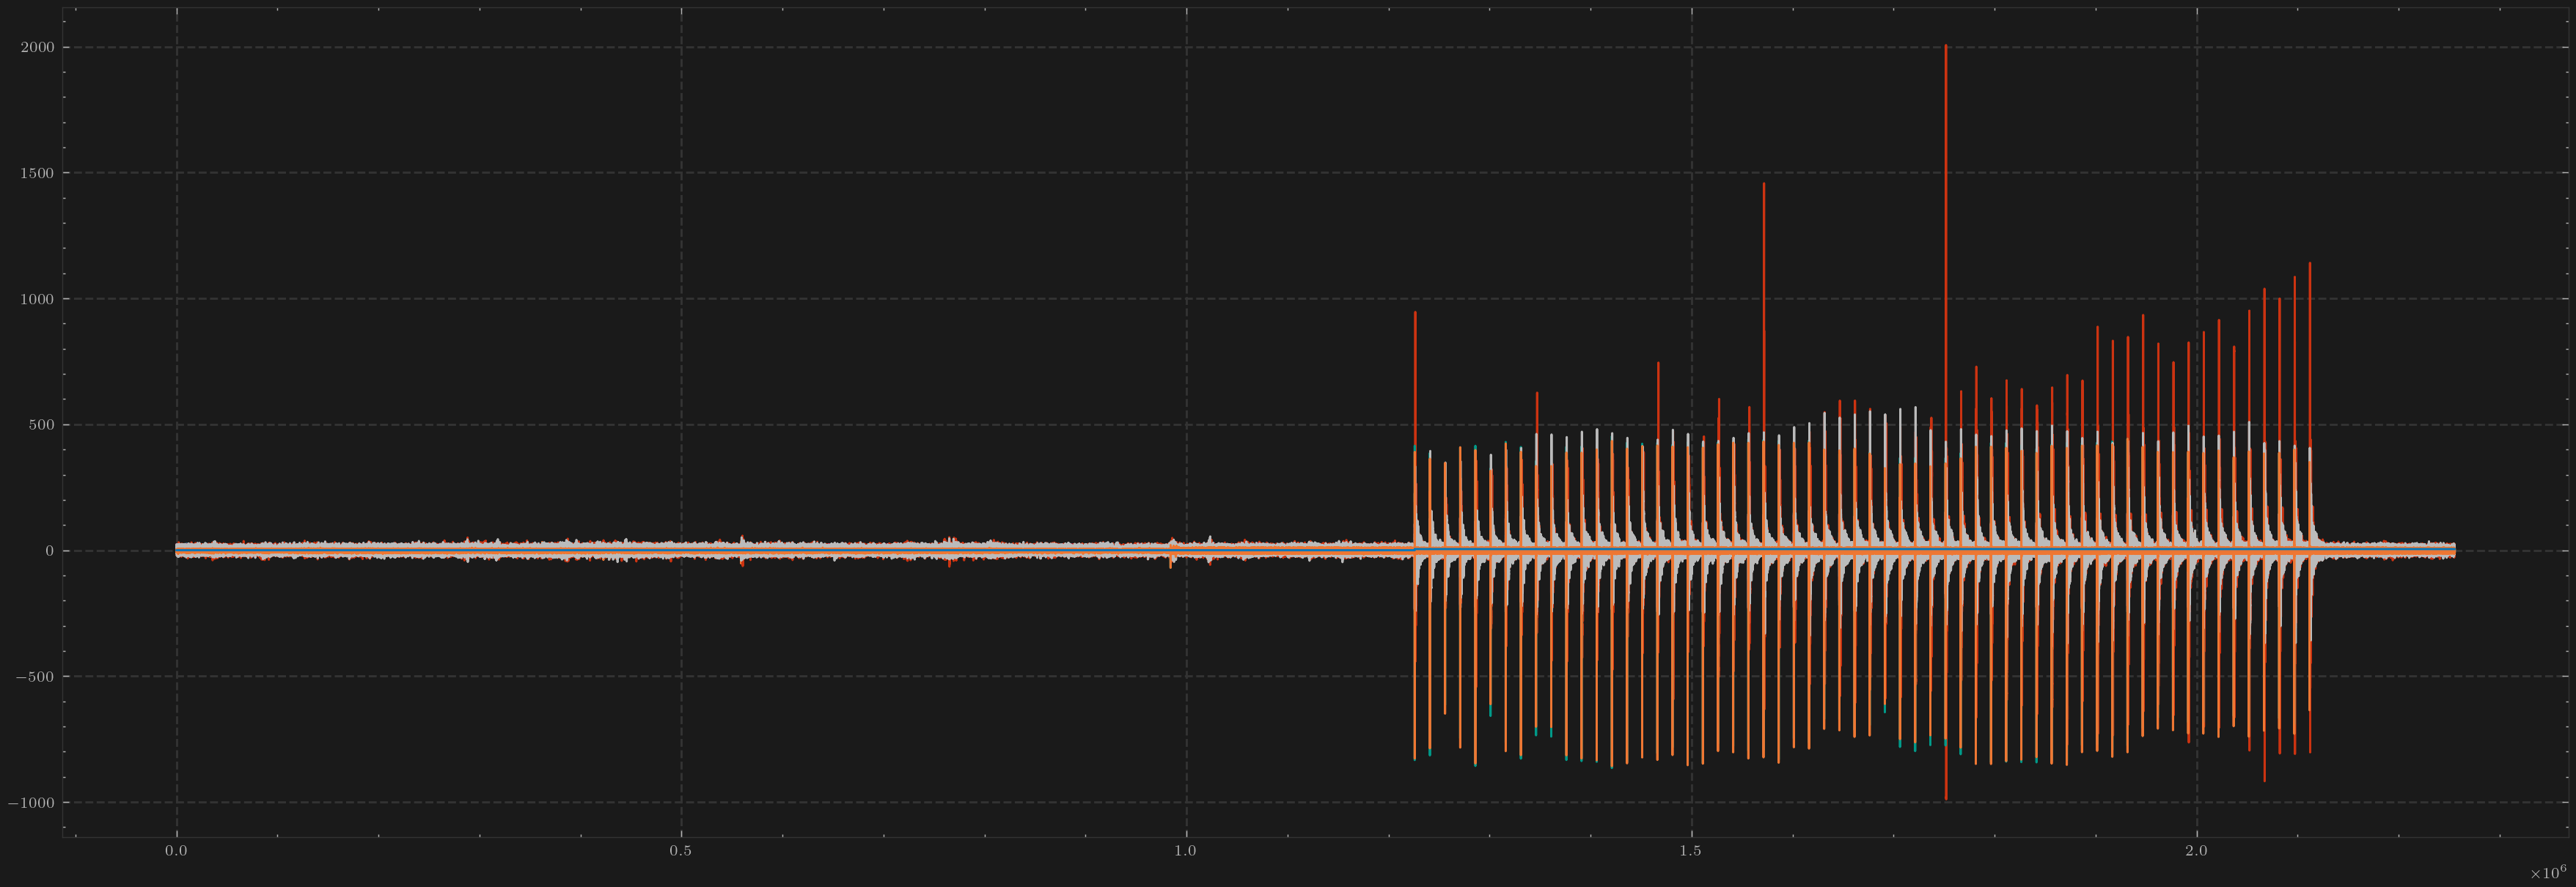

In [20]:
# plot the raw data
plt.figure(figsize=(21, 7), dpi=210)
plt.plot(raw_data)

## task two: identify the event channel and extract event timings
### visually inspect the raw data to identify the event channel

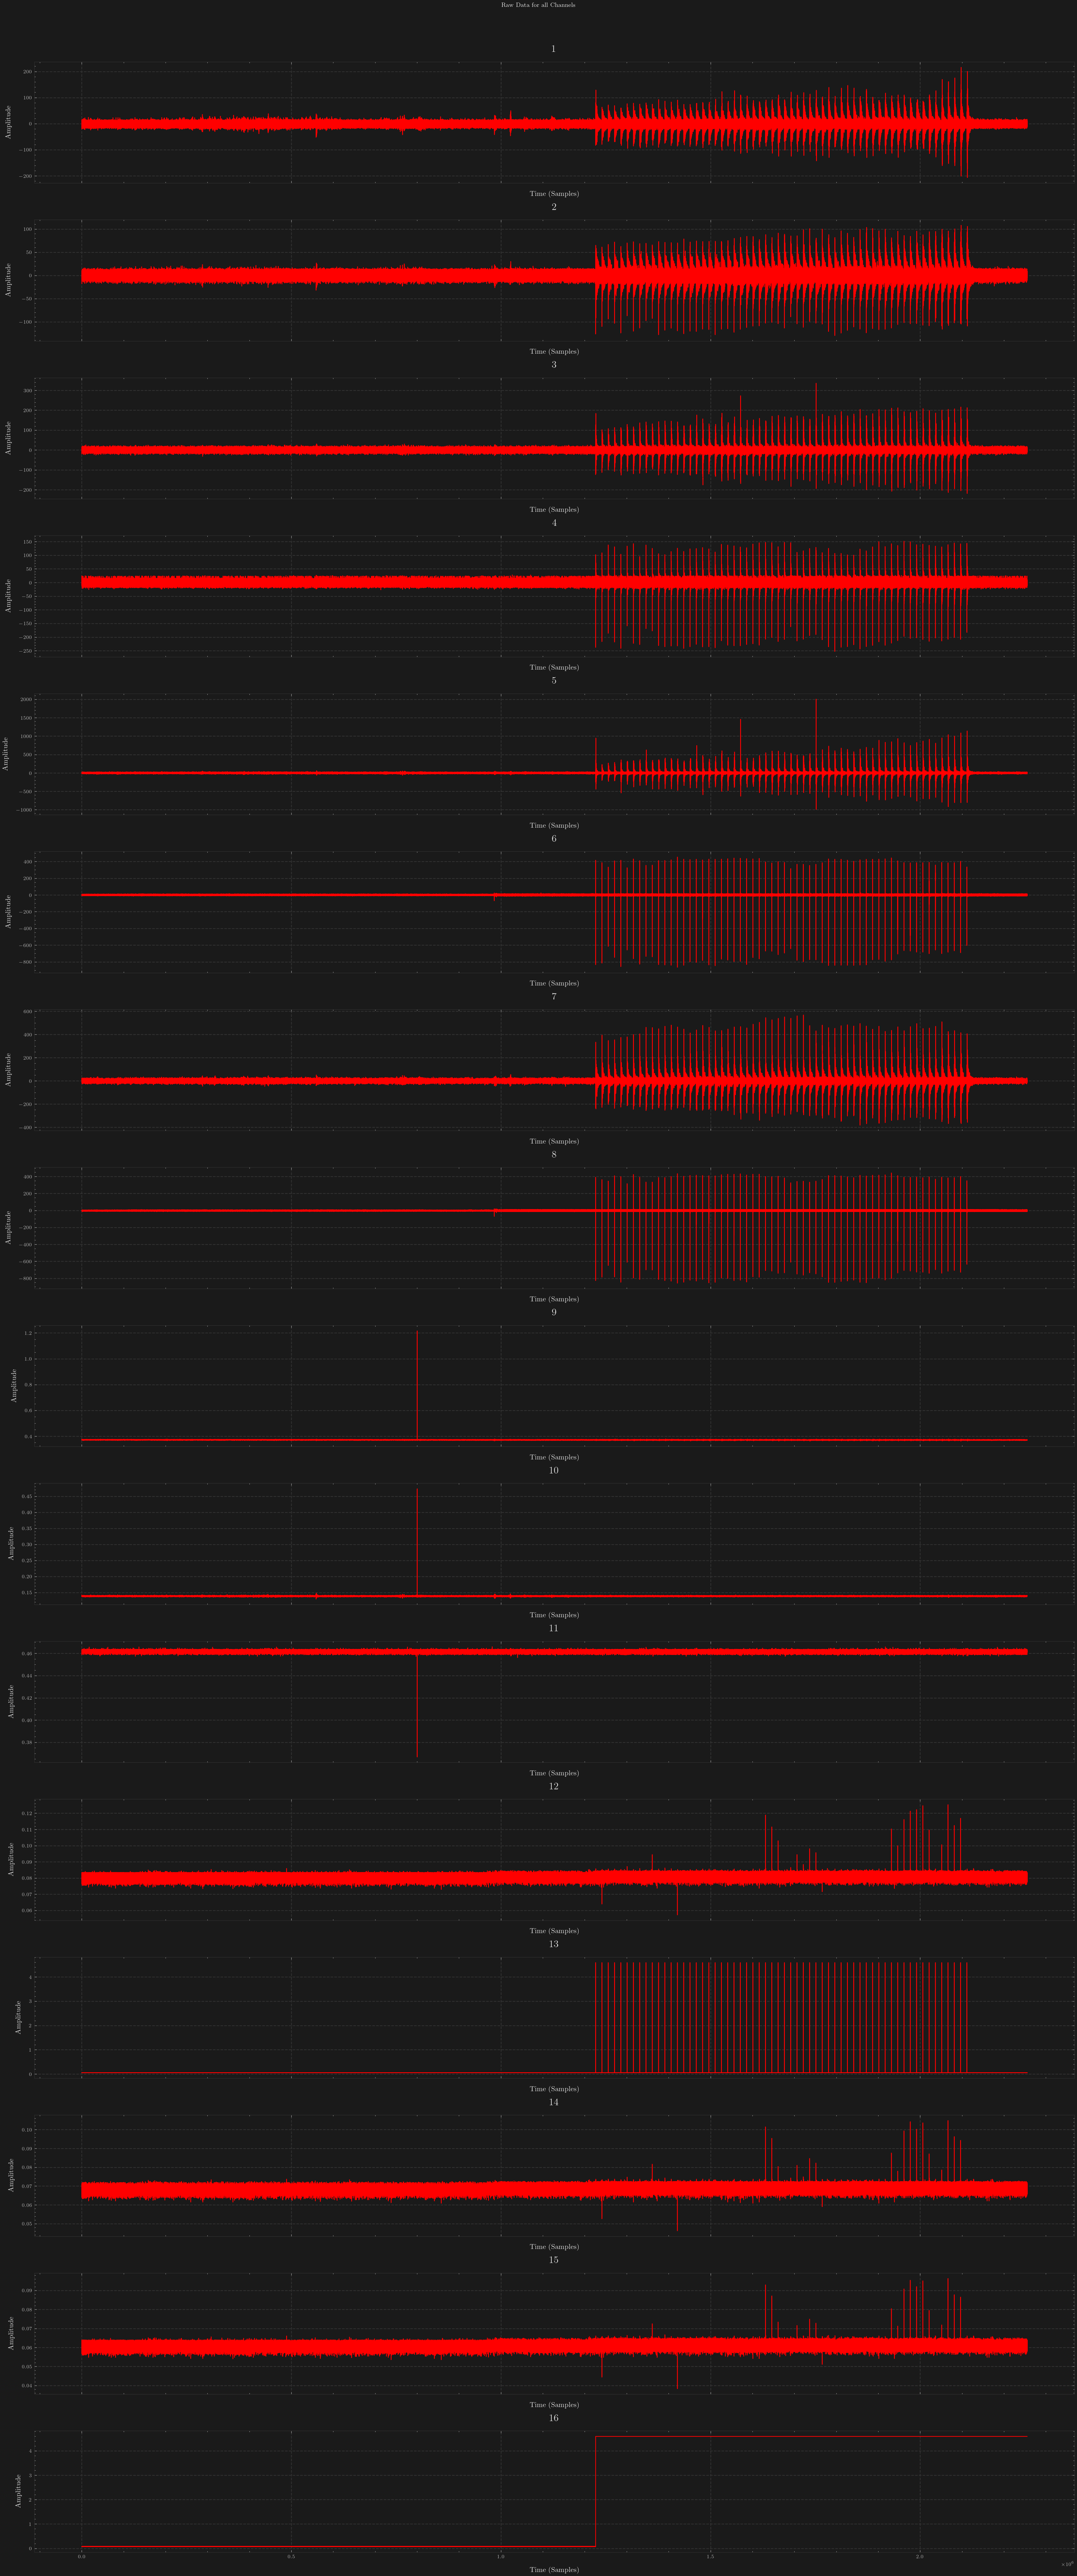

16


In [21]:
channel_names = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16}

fig1, axs1 = plt.subplots(16, 1, figsize=(21, 16*3 + 3), sharex = True)

count = 0
all_channels = {}

for i in range(0,16):

    # storing each sample as an individual array
    channel_data = (recording.continuous[0].get_samples(start_sample_index=0, end_sample_index=data_length, selected_channels=[i])).flatten()

    all_channels[channel_names[i]] = channel_data

    # plotting all the data
    time_axis = [t for t in range(len(channel_data))]
    axs1[i].plot(time_axis, channel_data, color = 'red')
    axs1[i].set_title(f'Channel {channel_names[i]}')
    axs1[i].set_xlabel('Time (Samples)')
    axs1[i].set_ylabel('Amplitude')

    count+=1

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.4, wspace=0.4)
fig1.suptitle('Raw Data for all Channels', fontsize=21)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

fig1.savefig(os.path.join(path_for_extracted, 'raw_data.png'))
print(count)

### plotting and exploring our event channel

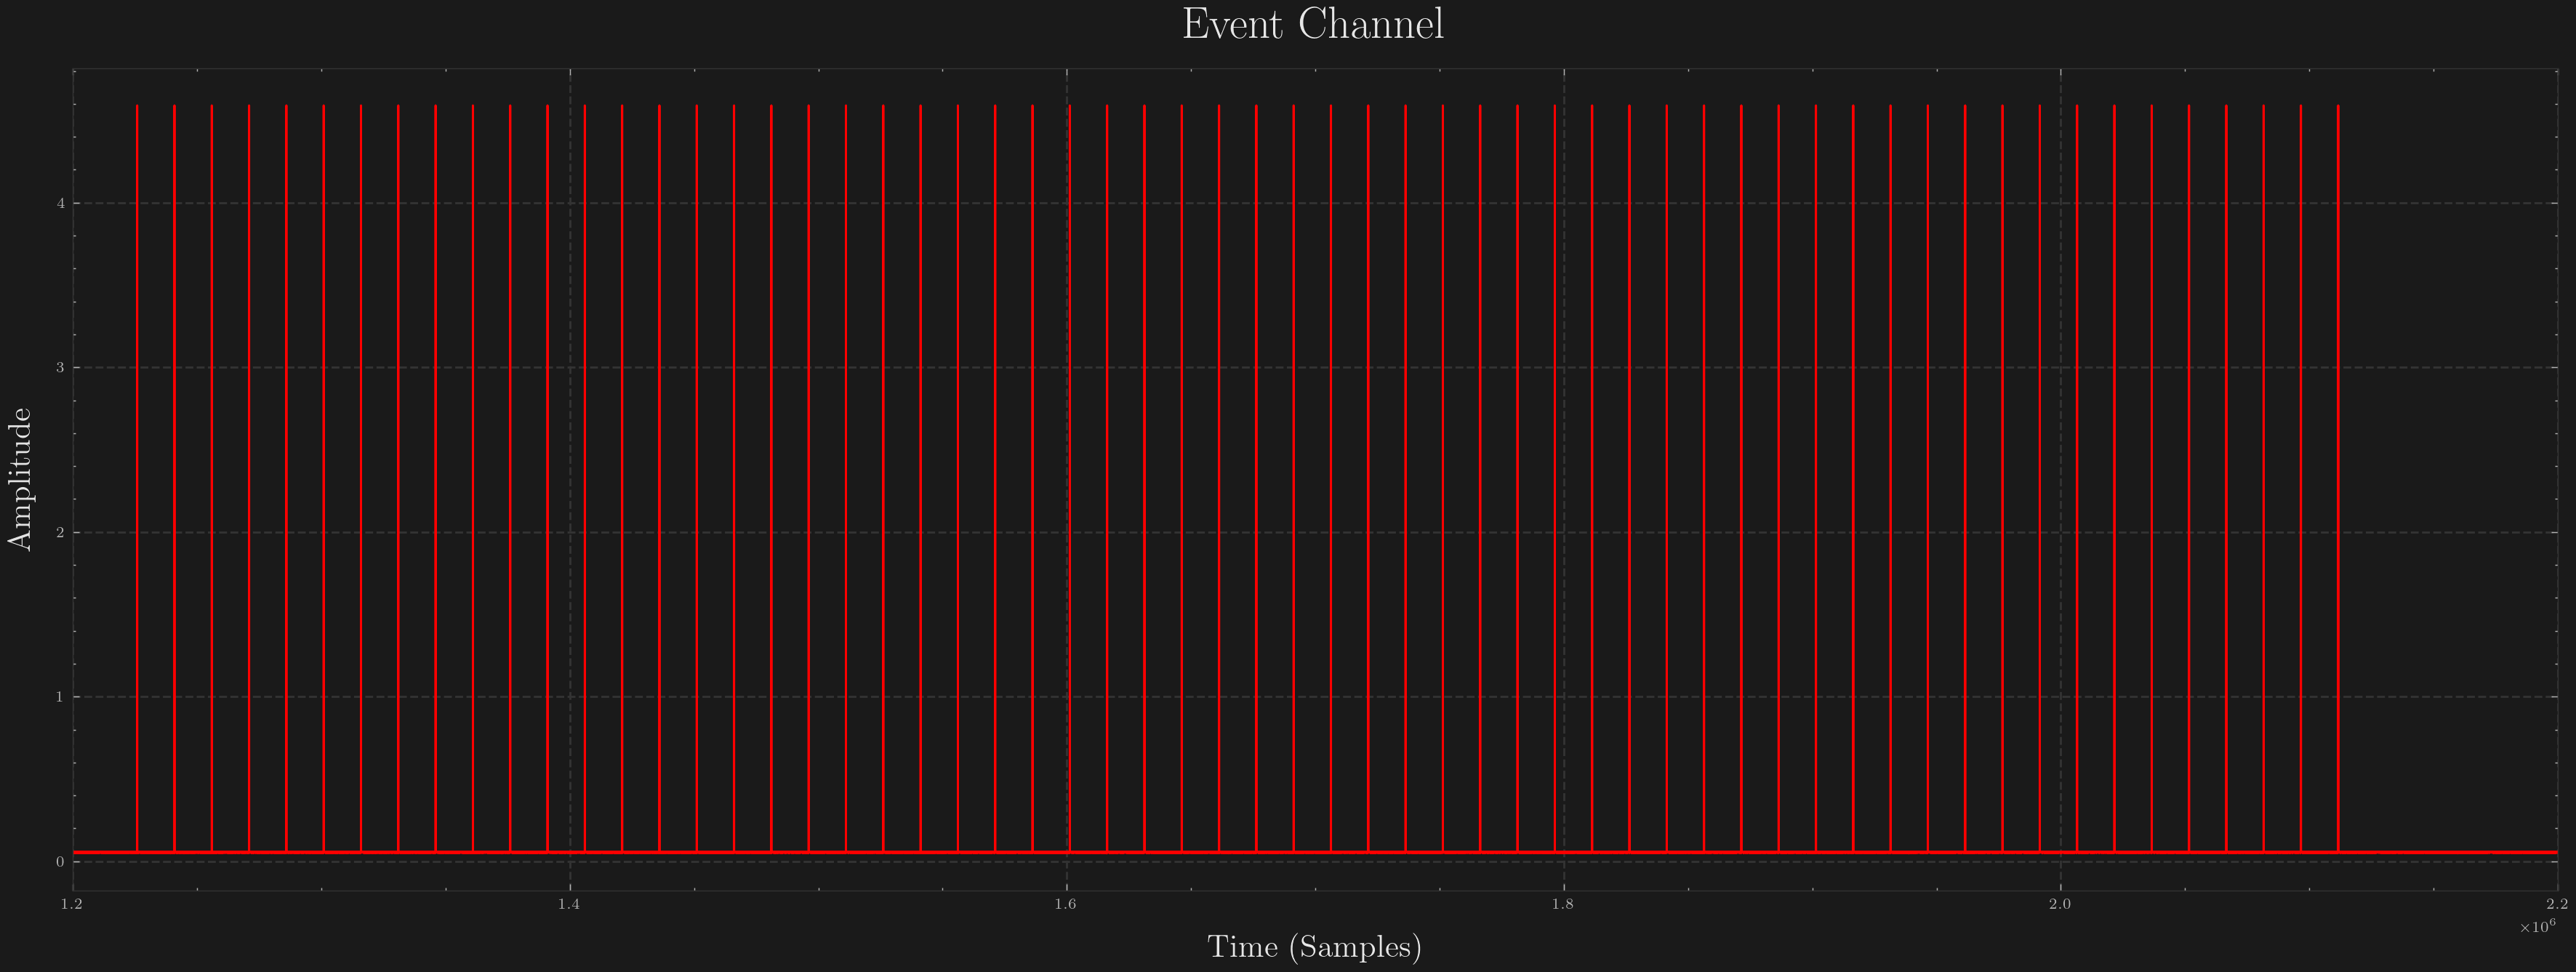

In [29]:
event_channel = raw_data[:, 12]

plt.figure(figsize=(21, 7), dpi=210)
plt.plot(event_channel, color = 'red')
plt.title('Event Channel', fontsize=21)
plt.xlabel('Time (Samples)', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.xlim(1.2e6, 2.2e6)
plt.show()

### extract event timings

In [ ]:
def extract_events(self, event_channel_number: int, export=True):
    
    # optional type and value checks to improve robustness
    # if not isinstance(event_channel_number, int):
    #     raise TypeError('event_channel_number must be an integer')
    # 
    # if event_channel_number < 1 or event_channel_number > self.num_channels:
    #     raise ValueError('event_channel_number must be within the valid range of channels')

    data = raw_data
    threshold = 0.5  # threshold for detecting events which are always above 0.5
    event_channel_data = data[:, event_channel_number - 1]

    # Detect event locations using vectorized operations
    above_threshold = event_channel_data >= threshold
    event_start_indices = np.where(np.diff(above_threshold.astype(int)) == 1)[0] + 1
    event_end_indices = np.where(np.diff(above_threshold.astype(int)) == -1)[0]

    # Handle the case where an event starts but does not end within the data
    if above_threshold[0]:
        event_start_indices = np.insert(event_start_indices, 0, 0)
    if above_threshold[-1]:
        event_end_indices = np.append(event_end_indices, len(event_channel_data) - 1)

    events = {i + 1: (int(start), int(end)) for i, (start, end) in enumerate(zip(event_start_indices, event_end_indices))}

    self.events = events

    if export:
        self._save_object(events, 'extracted_events', 'json')

    return events